# The Avellaneda-Stoikov model and its variants

This notebook introduces the market-making model of [Avellaneda and Stoikov](https://math.nyu.edu/~avellane/HighFrequencyTrading.pdf) and shows how it is implemented in `mbt_gym`


### Import external modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np

### Add mbt-gym to path and import

In [3]:
import sys
sys.path.append("../../")

from mbt_gym.agents.BaselineAgents import AvellanedaStoikovAgent, CarteaJaimungalMmAgent, FixedSpreadAgent
from mbt_gym.gym.helpers.plotting import generate_trajectory,plot_trajectory
from mbt_gym.gym.TradingEnvironment import TradingEnvironment
from mbt_gym.gym.ModelDynamics import LimitOrderModelDynamics
from mbt_gym.rewards.RewardFunctions import CjMmCriterion, PnL
from mbt_gym.stochastic_processes.midprice_models import BrownianMotionMidpriceModel
from mbt_gym.stochastic_processes.arrival_models import PoissonArrivalModel
from mbt_gym.stochastic_processes.fill_probability_models import ExponentialFillFunction

## The financial market model

- Goal of Avellaneda and Stoikov is to model a limit order book in a reduced form
- Instead of modelling each level of the order book (as done in [Farmer et al. (2005)](https://www.pnas.org/doi/epdf/10.1073/pnas.0409157102) or [Cont et al. (2010)](http://rama.cont.perso.math.cnrs.fr/pdf/CST2010.pdf) for example), we only model certain statistics
- This reduces the dimensionality of the problem massively 
- The rest of this notebook introduces the ingredients of such a model

### Midprice processes

- Classically, this has been modelled as a *geometric Brownian motion* (prototypical example: Black–Scholes–Merton model for option pricing)
- However, AS uses *arithmetic Brownian motion* (with zero drift) 
- The two are practically indistinguishable over short time periods (crucially assumed in our case)
- `BrownianMotionMidpriceModel` is given by $$S_t = S_0 + \mu\,t+ \sigma\,W_t$$

In [88]:
seed = 1729

In [89]:
# First, let's consider a single dimensional Brownian motion
sigma = 1  # Volatility of the Brownian motion
bm = BrownianMotionMidpriceModel(volatility=sigma, seed=seed)
bm.reset()
print(f"The initial state of the Brownian motion is {bm.current_state}. Note that it is a column vector. Also, " 
      + f"note that bm.num_trajectories = {bm.num_trajectories}.")

The initial state of the Brownian motion is [[100]]. Note that it is a column vector. Also, note that bm.num_trajectories = 1.


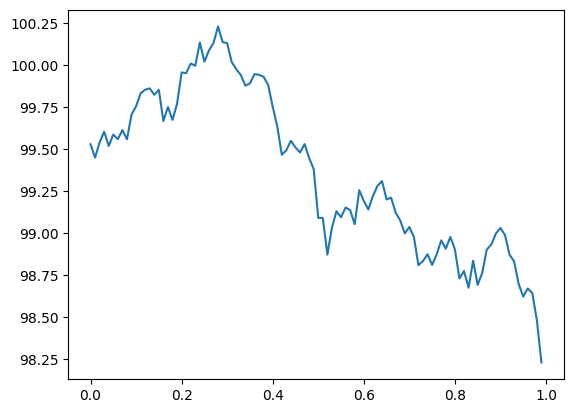

In [87]:
# Now, let's run a single trajectory
trajectory = []
for _ in range(int(1/bm.step_size)):
    trajectory.append(bm.current_state.item())
    bm.update(arrivals=None, fills=None, actions=None, state=None)  # See below
plt.plot(np.arange(0, bm.terminal_time, bm.step_size), trajectory)

- **Note:** to `update` the Midprice model, we need to pass arrivals, fills, and actions
- This is to allow the flexibility for the midprice to depend upon, market order arrivals, fills and even the action of the agent! 

- `MidpriceModel`s are inherently vectorised using numpy
- This means that -- unlike in most other reinforcement learning problems, which rely on multiprocessing to vectorise -- we can *directly* simulate a large number of trajectories
- Let's simulate 100,000 trajectories and see how long it takes

In [90]:
n_traj = 100_000
initial_price = 50
bm = BrownianMotionMidpriceModel(volatility=sigma, num_trajectories=n_traj, seed=seed, initial_price=initial_price)
bm.reset()
print(f"The initial 'state' of the vectorized Brownian motion now has dimension {len(bm.current_state)}.")

The initial 'state' of the vectorized Brownian motion now has dimension 100000.


In [91]:
%%time
trajectories = []
for _ in range(int(1/bm.step_size)):
    trajectories.append(bm.current_state)
    bm.update(arrivals=None, fills=None, actions=None)
trajectories = np.concatenate(trajectories, axis=1).T

CPU times: user 115 ms, sys: 18.2 ms, total: 133 ms
Wall time: 134 ms


![vectorization](images/numpy-vs-concurrent-crop.png)

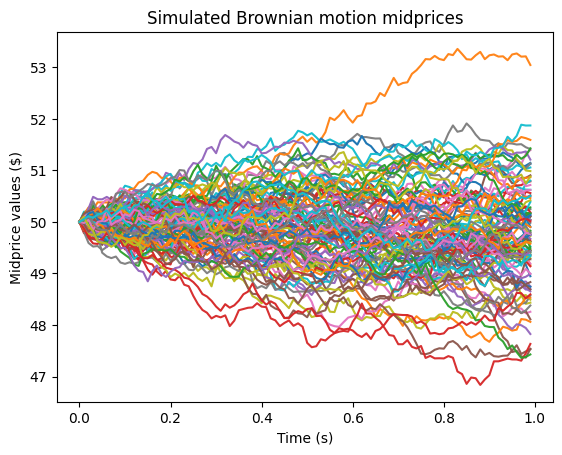

In [92]:
n_to_show = 100
times = np.arange(0, bm.terminal_time, bm.step_size).reshape(n_to_show,1).repeat(n_traj, axis=1)
for i in range(100):
    plt.plot(times[:,i], trajectories[:,i], 
             alpha = 1-(np.abs(initial_price-trajectories[-1,i]))/max(np.abs(n_to_show-trajectories[-1,:n_to_show])));
plt.xlabel("Time (s)"); plt.ylabel("Midprice values (\$)")
plt.title("Simulated Brownian motion midprices"); plt.show()

#### Some implemented alternatives to Brownian motion

- `BrownianMotionJumpMidpriceModel`, whose dynamics follow $$S_t = S_0 + \sigma\, W_t - \xi^-\, M^-_t + \xi^+\,M^+_t\,,$$  where $M^\pm_t$ are the buy/sell market orders from liquidity takers and $\xi^\pm \in\mathbb{R}^+$ are the permanent price impact parameters

#### Some implemented alternatives to Brownian motion

- `OuJumpDriftMidpriceModel` whose dynamics are given by
$$\text{d} S_t = \alpha_t\,\text{d} t + \sigma^S\,\text{d} W^S_t$$
where
$$
    \text{d}\alpha_t = \kappa^\alpha (\bar{\alpha} - \alpha_t)\,\text{d} t +\sigma^\alpha\,\text{d} W^\alpha_t  - \xi^-\, M^-_t + \xi^+\,M^+_t
$$
This models a stochastic process whose drift is a signal with a mean-reverting (Ornstein–Uhlenbeck) part and jumps dependent upon the market order arrivals

### Arrivals processes

- Next we consider arrivals of market orders on each side of the book 
- The model of Avellaneda and Stoikov uses Poisson processes $(M^\pm_t)_{t\geq 0}$ to model these 
- The intensities of these Poisson processes are $\lambda^\pm\in\mathbb{R}^+$ 
- A popular generalisation of these are *self-exciting* Hawkes processes

In [93]:
intensity = np.array([15., 15.])  # The intensity of the Poisson process
pp = PoissonArrivalModel(intensity=intensity, seed=seed)
pp.reset()
print(f"The (initial) state of the Poisson process is {pp.current_state}, i.e. it is stateless. A Hawkes process " + 
      "would have state given by its intensity process.")

The (initial) state of the Poisson process is [], i.e. it is stateless. A Hawkes process would have state given by its intensity process.


In [94]:
# Again, we show a single trajectory
pp.reset()
market_arrivals_bid = []
market_arrivals_ask = []
for _ in range(int(1/pp.step_size)):
    pp.update(arrivals=None, fills=None, actions=None)  
    market_arrival = pp.get_arrivals()
    market_arrivals_bid.append(market_arrival[:,0])
    market_arrivals_ask.append(market_arrival[:,1])

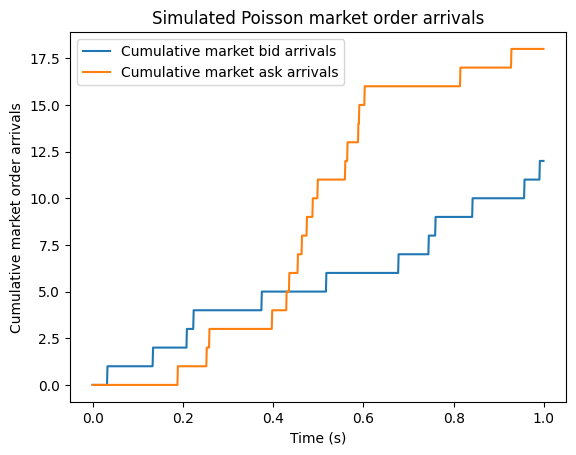

In [95]:
plt.plot(np.arange(0, 1.0, pp.step_size), np.cumsum(market_arrivals_bid), label="Cumulative market bid arrivals")
plt.plot(np.arange(0, 1.0, pp.step_size), np.cumsum(market_arrivals_ask), label="Cumulative market ask arrivals")
plt.xlabel("Time (s)"); plt.ylabel("Cumulative market order arrivals")
plt.title("Simulated Poisson market order arrivals"); plt.legend(); plt.show()

### Fill probabilities

* Given that a market order arrives and "walks the book", what is the probability that the agent's limit order gets filled?  
* AS use an `ExponentialFillFunction` (parametrized by fill exponent parameters $\kappa^+>0,\kappa^->0$ for the ask/bid sides of the book)
* Then, if agent posts at depth $\delta^+$ on the ask side, the probability that the recently arrived market order fills their limit order is
$$\mathbb{P}(fill\,|\,\delta^+) = e^{-\kappa^+\delta^+}$$

In [96]:
# hyperparameter
start = 0
#end = 100
step_size = 0.1

fill_prob_fn = ExponentialFillFunction(fill_exponent=0.1)

depths = np.arange(0, fill_prob_fn.max_depth + 0.01, 0.01)
fill_probs = fill_prob_fn._get_fill_probabilities(depths=depths)

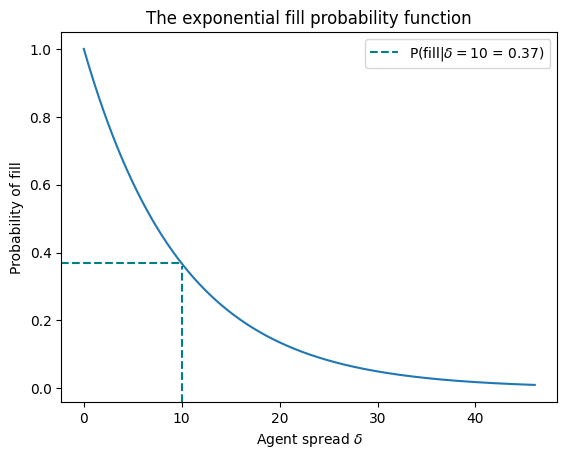

In [99]:
plt.plot(depths, fill_probs)
plt.axvline(x=10, ymax=fill_prob_fn._get_fill_probabilities(depths=10), color='teal', ls='--',\
                label = rf"P(fill|$\delta=10$ = {np.round(fill_prob_fn._get_fill_probabilities(depths=10), 2)})")
plt.axhline(y=fill_prob_fn._get_fill_probabilities(depths=10), xmax=(10+1)/fill_prob_fn.max_depth, color='teal', ls='--')
plt.xlabel(r"Agent spread $\delta$"); plt.ylabel("Probability of fill")
plt.title("The exponential fill probability function"); plt.legend(); plt.show()

## Reward functions

- Let $T>0$ and $\mathfrak{T} = [0,T]$
- we use $(X_t)_{t\in\mathfrak{T}}$ for the cash process of the trader, $(Q_t)_{t\in\mathfrak{T}}$ for the inventory, and $(S_t)_{t\in\mathfrak{T}}$ the midprice process

## Reward functions

- `PnL` (for ``profit and loss'', aka risk-neutral reward) computes the changes in the mark-to-market value of the trader's position $$Y_t := X_t + Q_tS_t$$ 
- Specifically, `PnL` can be written as $$Y_T - Y_0$$

## Reward functions
- `ExponentialUtility` reward takes a `risk_aversion` parameter $\gamma>0$ and computes $$\exp\left(-\gamma\left(Y_T-Y_0\right)\right)$$

## Reward functions
- `RunningInventoryPenalty` has parameters: the `per_step_inventory_aversion`, denoted by  $\phi\geq 0$, and the `terminal_inventory_aversion`, denoted by $\alpha\geq 0$
- The episodic reward is then defined as the time-discretised version of \begin{equation}\label{eq:running_penalty_reward}
R^{\rm CJ}_T = Y_T - Y_0 - \alpha\,Q_T^2 -\phi\int_0^T Q_t^2 dt
\end{equation}

## Creating a `mbt_gym` environment using these stochastic processes

In [104]:
sigma= 0.01 # constant "volatility" of midprice process
arrival_rate = 30.0 # lambda
fill_exponent = 100 # kappa
phi = 0.0002 # per_step_inventory_aversion
alpha = 0.0001 # terminal_inventory_aversion

terminal_time = 1.0
max_inventory = 3
initial_price = 100
n_steps = int(10 * terminal_time * arrival_rate)
step_size = 1/n_steps # small enough that probability of an arrival in a step is small enough
# (simulating a geometric random variable with a Bernouilli)

In [105]:
def get_env(num_trajectories:int = 1, seed:int=None, is_cj:bool=False):    
    timestamps = np.linspace(0, terminal_time, n_steps + 1)
    midprice_model = BrownianMotionMidpriceModel(volatility=sigma, step_size=1/n_steps,
                                                 num_trajectories=num_trajectories)
    arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), 
                                        step_size=1/n_steps, 
                                        num_trajectories=num_trajectories)
    fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                     step_size=1/n_steps,
                                                     num_trajectories=num_trajectories)
    LOtrader = LimitOrderModelDynamics(midprice_model = midprice_model, arrival_model = arrival_model, 
                                fill_probability_model = fill_probability_model,
                                num_trajectories = num_trajectories)
    reward_function = CjMmCriterion(per_step_inventory_aversion,terminal_inventory_aversion) if is_cj else PnL()
    env_params = dict(terminal_time=terminal_time, 
                      n_steps=n_steps,
                      model_dynamics = LOtrader,
                      max_inventory=max_inventory,
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      reward_function = reward_function,
                      num_trajectories=num_trajectories,
                      seed=seed)
    return TradingEnvironment(**env_params)

## Interacting with the environment using agents

Next we look at the trajectories from a variety of different agents and investigate their performance. We investigate the:

1. `FixedSpreadAgent`, an agent that quotes a symmetric fixed spread at all times -- we investigate a variety of different spreads
2. `AvellanedaStoikovAgent`, that quotes the quasi-optimal time and inventory dependent spreads to maximise `TerminalExponentialUtility` -- see [the original paper of Avellaneda and Stoikov](https://math.nyu.edu/~avellane/HighFrequencyTrading.pdf)
3. `CarteaJaimungalMmAgent`, that quotes the optimal strategy to maximise the `CarteaJaimungalCriterion` defined in Section 10.2 of [Cartea, Jaimungal and Penalva (2015)](https://www.amazon.co.uk/Algorithmic-High-Frequency-Trading-Mathematics-Finance-ebook/dp/B012GS2MY0)

### `FixedSpreadAgent`

In [106]:
half_spreads = [0.0001,0.001,0.01,0.1]
env = get_env()
performance_dict = {}
for hs in half_spreads:
    np.random.seed(45)
    agent = FixedSpreadAgent(env, half_spread=hs)
    performance_dict[hs] = {}
    performance_dict[hs]["observations"], performance_dict[hs]["actions"],\
                        rewards = generate_trajectory(env,agent, seed = seed)
    performance_dict[hs]["cum_rewards"] = np.cumsum(rewards)

In [109]:
def plot_fs():
    fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize = (20,10))

    ax1.title.set_text("cum_rewards")
    ax2.title.set_text("asset_prices")
    ax3.title.set_text("inventory")
    ax4.title.set_text("cash_holdings")

    timestamps = np.linspace(0, terminal_time, n_steps + 1)

    for hs in half_spreads:
        ax1.plot(timestamps[1:],performance_dict[hs]["cum_rewards"], label = hs)
        ax2.plot(timestamps,performance_dict[hs]["observations"][:,3].reshape(-1), label = hs)
        ax3.plot(timestamps,performance_dict[hs]["observations"][:,1].reshape(-1), label = hs)
        ax4.plot(timestamps,performance_dict[hs]["observations"][:,0].reshape(-1), label = hs)
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax4.legend()
    plt.suptitle("Trajectories for fixed spread agents with different spreads", fontsize=20)
    plt.show()

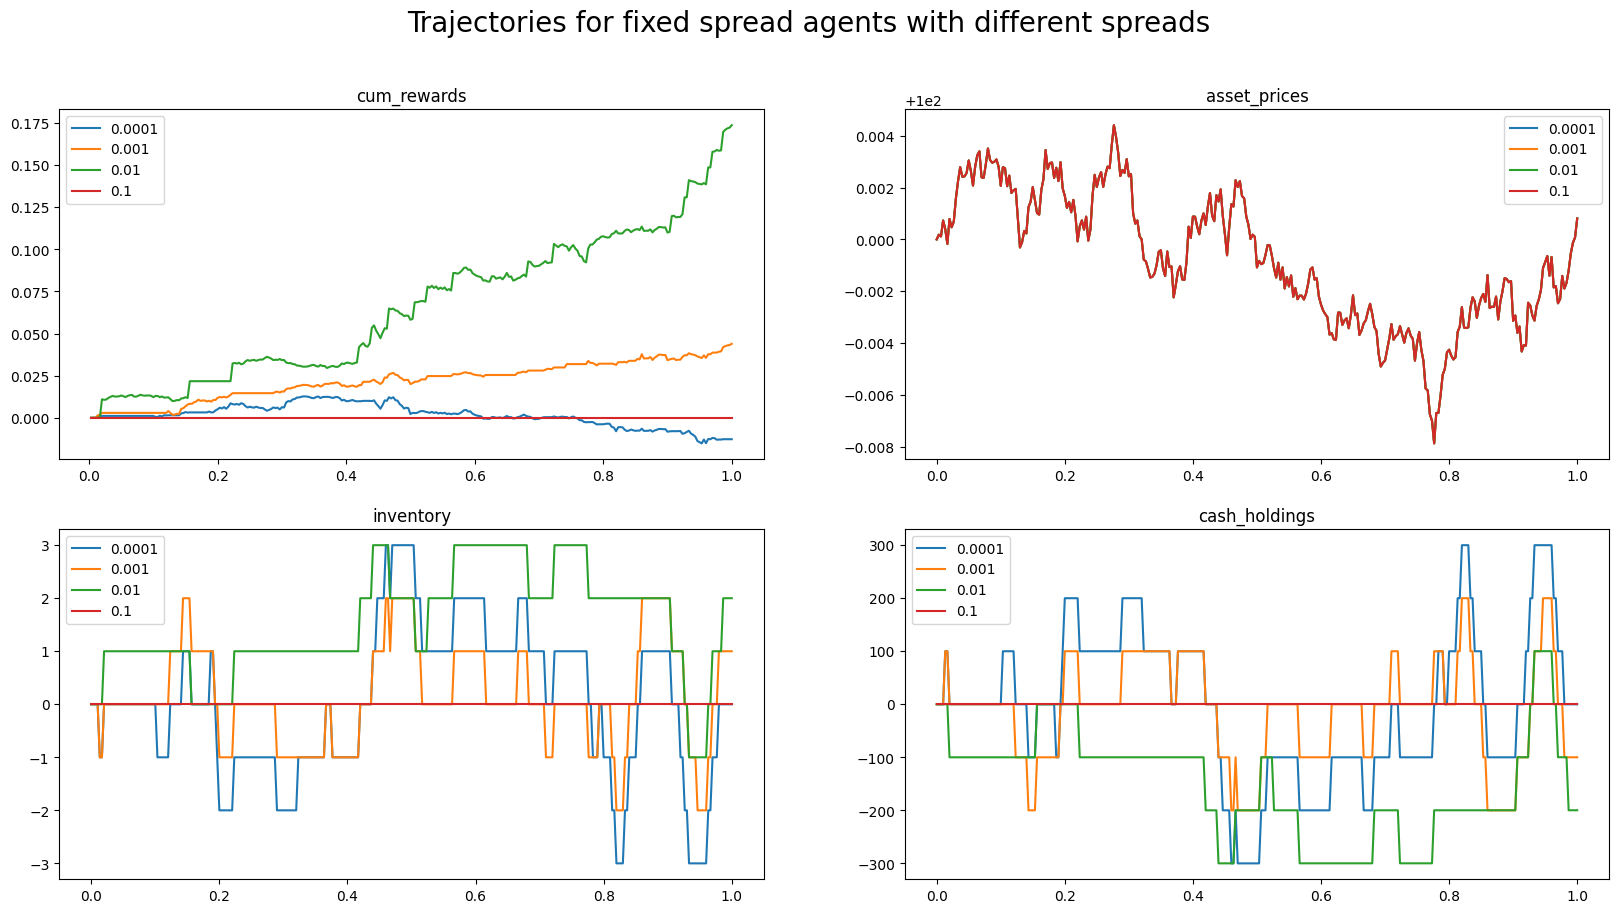

In [110]:
plot_fs()

### The Avellaneda and Stoikov market-making agent

- Aims to optimise the `TerminalExponentialUtility` for a given level of *risk aversion* parameterised by $\gamma>0$
- As we will see, it automatically skews its relative midprice and increases/decrease spread according to its level of inventory as well as the time remaining until the end of the episode
- The solution given is quasi-optimal for the problem in the sense that Avellaneda and Stoikov make a first order approximation to the Hamilton--Jacobi--Bellman equation to be able to solve it

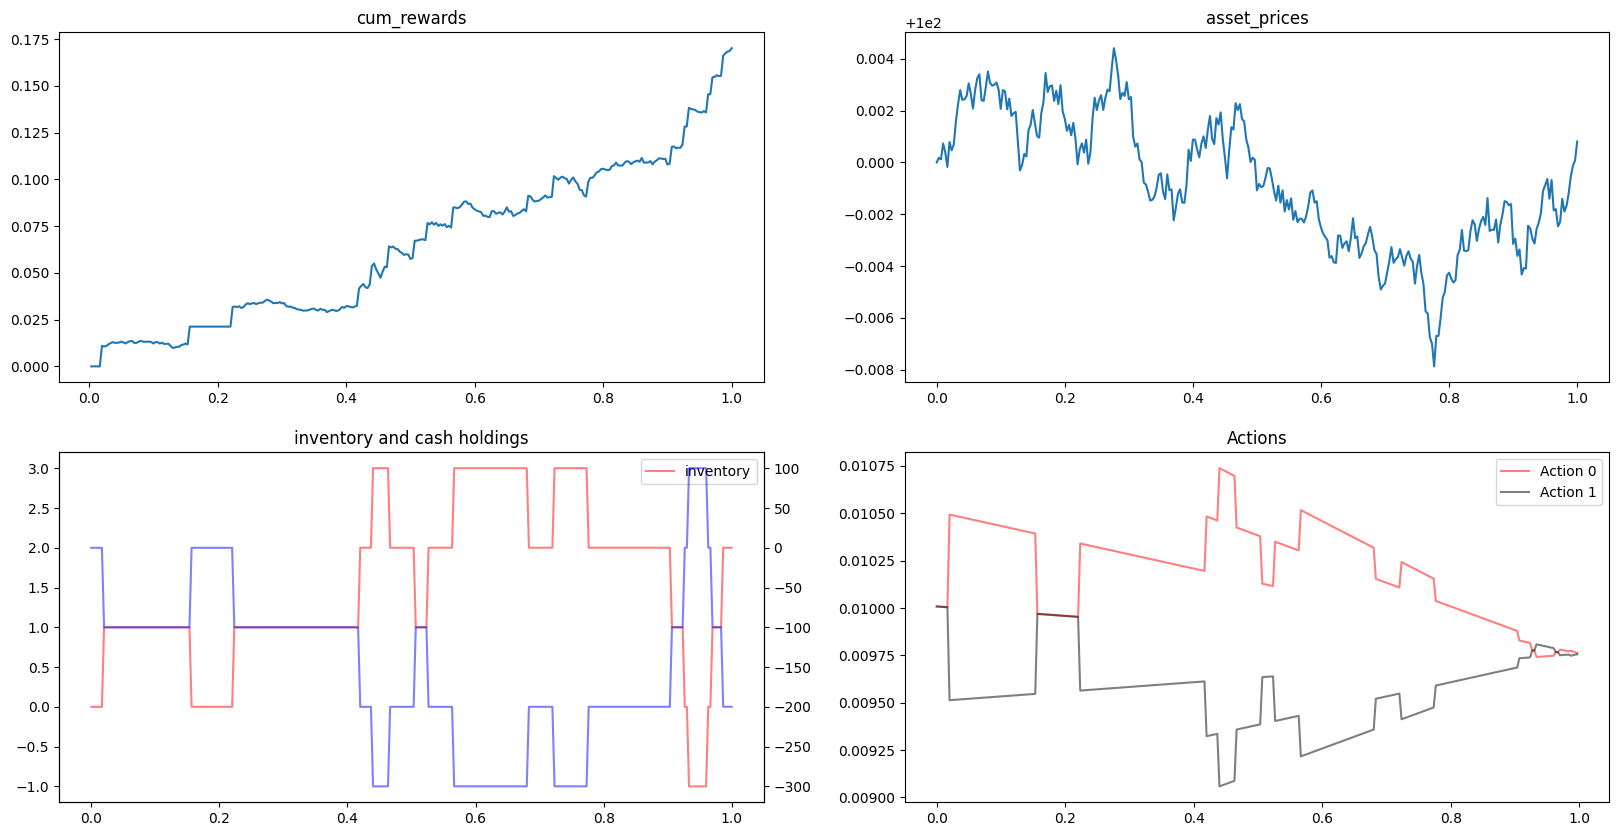

In [19]:
as_agent = AvellanedaStoikovAgent(risk_aversion=5, env=env)
env.reset()
plot_trajectory(env, as_agent, seed = seed)

### The Cartea, Jaimungal and Penalva market-making agent

- Aims to optimise the `InventoryAdjustedPnL` of the agent for a given level of *inventory aversion* parameterised by $\phi,\alpha>0$
- Again, it skews its relative midprice and increases/decreases the spread according to its level of inventory as well as the time remaining until the end of the episode
- The solution given is derived and proven to be optimal in Section 10.2 of [Cartea, Jaimungal and Penalva (2015)](https://www.amazon.co.uk/Algorithmic-High-Frequency-Trading-Mathematics-Finance-ebook/dp/B012GS2MY0)

In [111]:
per_step_inventory_aversion = 0.01
terminal_inventory_aversion = 0.0001

cj_agent = CarteaJaimungalMmAgent(get_env(is_cj=True))
env.reset()


array([[  0.,   0.,   0., 100.]])

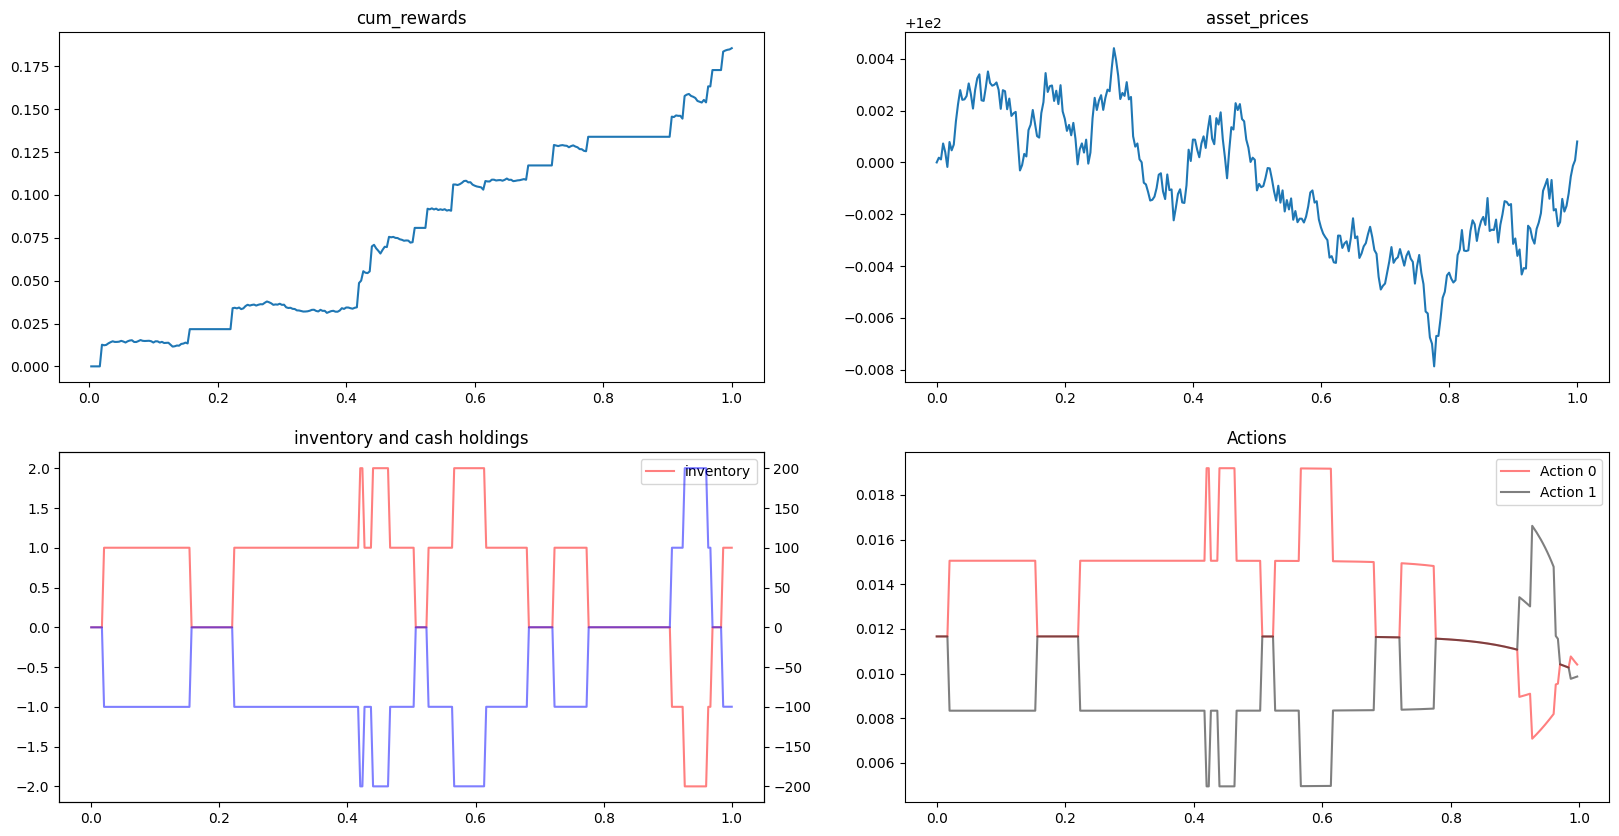

In [112]:
plot_trajectory(env, cj_agent, seed = seed)

# That's the end of this noteook; in the next one we'll do some RL